In [57]:
import numpy as np
import pandas as pd
import zipfile
import re
from tinydb import TinyDB, Query
import random
import urllib as urllib2
import nltk
from nltk.tokenize import ToktokTokenizer
from bs4 import BeautifulSoup
import wget, os
import time

## database

In [12]:
content_db = TinyDB('../database/db.json')

## downloading txt files

In [13]:
def get_links():
    url = 'https://www.google.com/googlebooks/uspto-patents-grants-text.html'
    resp = urllib2.request.urlopen(url)
    soup = BeautifulSoup(resp.read())
    links = [a['href'] for a in soup.find_all('a', href=True)]
    return links[733:]
zips = get_links()

In [14]:
def extract_zip(z, zip_path, txt_path):
    zip_dir = zip_path + z[-10:]
    
    try:
        filename = wget.download(z, out = zip_dir)
    except:
        return None
    
    zip_ref = zipfile.ZipFile(zip_dir, 'r')
    zip_ref.extractall(txt_path)
    zip_ref.close() 
    return zip_dir

In [15]:
def get_txt_content(filepath, approved):
    # returns raw text and relevant metadata
    def approve_line(line, approved):
        if not line[2].isupper(): return True
        for a in approved:
            if a in line:
                return True
        return False

    contents = []
    for line in open(filepath, 'rb'):
        if approve_line(str(line), approved): 
            contents.append(str(line.strip()))
    return contents

In [147]:
def preprocess_doc(docs):
    new_docs = []
    toktok = ToktokTokenizer()
    to_remove = [r'FIG. [1-9]', 'PAL', 'b\'', '\'']
    
    stopword_list = nltk.corpus.stopwords.words('english')
    
    stopword_list.append('said')
    stopword_list.append('b')
    stopword_list.remove('no')
    stopword_list.remove('not')
    
    for doc in docs:
        content = doc['content']
        for x in to_remove: content = re.sub(x, '', content)
        for x in to_remove: doc['id'] = re.sub(x, '', doc['id'])
        for x in to_remove: doc['title'] = re.sub(x, '', doc['title'])
        # tokenize
        tokens = toktok.tokenize(content)
        # save only alpha
        words = [str.lower(w) for w in tokens if w.isalpha()]
        filtered_tokens = [token for token in words if token not in stopword_list]
        #append to new_docs
        doc['content'] = filtered_tokens
        new_docs.append(doc)
    return new_docs

In [148]:
def get_patents_from_txt(contents): 
    
    def replace_text(text, to_remove):
        for x in to_remove: text = re.sub(x, '', text)
        return str(text).strip()
        
    patents = [] 
    patent = dict()
    curr_patent_txt = []
    for content in contents:
        if 'WKU' in content:
            if patent:
                patent['content'] = ' '.join(curr_patent_txt)
                patents.append(patent)
                patent = dict()
                curr_patent_txt = []
                #remove last number
            patent['id'] = content.replace('WKU  ', '')
            continue
        if 'TTL' in content:
            patent['title'] = content.replace('TTL  ', '')
            continue
        else:
            curr_patent_txt.append(content)
    return patents

In [132]:
def get_relevant_docs(contents, min_size):
    # returns docs with enough text for use
    return [c for c in contents if len(c["content"]) > min_size]

In [133]:
def store_docs(docs): 
# stores documents in database
    for doc in docs:
        doc['id'] = doc['id'][:-1]
        content_db.insert(doc)

In [134]:
zip_path = 'patent_zips/'
txt_path = 'patent_txt/'
txt_cutoff = 5
approved = ['TTL', 'PAL', 'FIG', 'WKU']
completed_patents = []
min_size = 1000

start = time.time()
for z in zips[txt_cutoff:txt_cutoff+1]:
    #get zip file from url
    zip_dir = extract_zip(z, zip_path, txt_path)
    if not zip_dir: continue
    os.remove(zip_dir)
    contents = get_txt_content(txt_path+os.listdir(txt_path)[0], approved)
    patents = get_patents_from_txt(contents)
    _patents = get_relevant_docs(patents, min_size)
    processed_patents = preprocess_doc(_patents)
    completed_patents.extend(processed_patents)
    os.remove(txt_path+os.listdir(txt_path)[0])
    
end = time.time()
print(end - start)

112.58439493179321


In [ ]:
store_docs(completed_patents)

#### example patent

In [151]:
print(completed_patents[0])

{'id': 'D04371003', 'title': 'Stick with detachable jointed elements which form a human skeleton for', 'content': ['frozen', 'confectionery', 'product', 'shows', 'front', 'perspective', 'view', 'first', 'embodiment', 'stick', 'detachable', 'jointed', 'elements', 'form', 'human', 'skeleton', 'frozen', 'confectionery', 'product', 'showing', 'skull', 'rib', 'rear', 'perspective', 'view', 'mirror', 'image', 'shows', 'rear', 'perspective', 'view', 'shows', 'front', 'perspective', 'view', 'second', 'embodiment', 'design', 'showing', 'bones', 'left', 'arm', 'shoulder', 'blade', 'rear', 'perspective', 'view', 'mirror', 'image', 'shows', 'rear', 'perspective', 'view', 'shows', 'front', 'perspective', 'view', 'third', 'embodiment', 'design', 'showing', 'bones', 'right', 'arm', 'shoulder', 'rear', 'perspective', 'view', 'mirror', 'image', 'shows', 'rear', 'perspective', 'view', 'shows', 'front', 'perspective', 'view', 'fourth', 'embodiment', 'design', 'showing', 'bones', 'left', 'leg', 'foot', 'k

## data exploration

In [145]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

In [135]:
corpus = []
for doc in completed_patents:
    corpus.extend(doc['content'])  

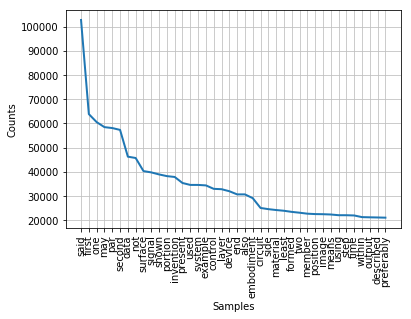

In [149]:
freq = nltk.FreqDist(corpus)
freq.plot(40, cumulative=False)

In [162]:
window = 15
for doc in completed_patents:
    print(doc['title'])
    

Stick with detachable jointed elements which form a human skeleton for
Four compartment tray
Embossed flower absorbent paper product
Figurine photograph holder
Multi-position chair
Seating product
Sleep surface
Folding table
Cabinet
Toothbrush cover and holding assembly
Post box with frame
Golf cart seat back cover
Case for digital disks
Compact disc storage wallet with identifying handle
Electric kettle
Stick blender
Ethel beverage container
Pull
Flat-sided bottle
Identifier
Wireless telementry unit
Postal security unit
Jewelry arrangement
Truck body
Motorcycle
Surface configuration of a motorcycle and toy
Tire tread
Tire tread
Hood for an automobile
Wheel
Railway car air brake reservoir mounting bracket
Cable connector insulator cover
Speaker box
Speaker box
Cable modem
Portable internet access device
Arithmetic and control unit
Camera for an electronic computer
Front panel for a computer workstation
Cutting head support frame
Model locomotive gearbox housing
Calculator with perpetua

Process and apparatus for preparation of silicon crystals with reduced
Method for preparing dense, epitaxial metal oxide film
Surface acoustic wave device, substrate therefor, and method of
Insulating and warming shield for a seed crystal and seed chuck
Air bellow suspended pipe lining machine
Method and apparatus for producing molecular film
Rotatable coating hopper
Particulate material blender and polisher
Coat weight measuring and control apparatus
Thermal protection system for a chemical vapor deposition machine
Apparatus for depositing thin films on semiconductor wafers
Buffer chamber for integrating physical and chemical vapor deposition
Method and apparatus for supporting a semiconductor wafer during processing
UV/halogen metals removal process
Graffiti removing method
Method for preparing a magnetic thin film
Cutting torch and associated methods
Surface treatment process of metallic material and metallic material
Permanent magnetic material and permanent magnet
Isotropic rare e

Memory cell with self-aligned floating gate and separate select gate, and
Field effect-controlled semiconductor component
Semiconductor device
I/O circuit that utilizes a pair of well structures as resistors to delay
Comparator having reduced offset voltage
Active matrix display device having multiple gate electrode portions
Photosemiconductor device mounted structure
Semiconductor pressure sensor having strain gauges and stress balance film
Strip detector
Device structure for providing improved Schottky barrier rectifier
Schottky diode with adjusted barrier height and process for its manufacture
Biasing of island-surrounding material to suppress reduction of breakdown
Method and structure for isolating semiconductor devices after transistor
Film capacitor and semiconductor package or device carrying same
Integrated circuit module having on-chip surge capacitors
Semiconductor chip inspection structures
Integrated circuit dies including thermal stress reducing grooves and
Method and app

Identifying the items most relevant to a current query based on items
Method and apparatus for dynamically counting large itemsets
System for automatically organizing data in accordance with pattern
Method and apparatus for providing and expression data mining database
Performing parallel cleanup of segments of a lock structure
Document management method and apparatus for ensuring consistency of
Generation and validation of reference handles in a multithreading
System and method for communication session disposition responsive to
Network management system having an embedded network database
Authenticated access to internet based research and data services
Classifying data packets processed by drivers included in a stack
Linked data structure integrity verification system which verifies actual
Method and apparatus for performing radix lookups using transition bits and
Compiler-assisted or interpreter-assisted solution to the year 2000 problem
Method for representing data from non-relati